<div class = "alert alert-block alert-info">
    <h1><font color = "red">DISCLAIMER</font></h1>
    <p>The approach <strong>Multi-Attention</strong> presented here is simply a research idea.  Verily we need to design a custom model and empirically impute attention mechanism within the model. But for demonstration purpose, here, we have simply tried to add a strong head to the pre-trained model. </p>
</div>

## <font color = "seagreen">Main Approaches</font>



```
- GroupStratify-KFold (K=5)
- Image Augmentation
    - General Augmentaiton (Albumentation)
- Image Modeling
    - EfficientNet + Custom Top Layers (Attention Mechanisms) + Sigmoid
- Training
         - 5 Fold Training 
         - OOF Evaluation: Optimizing Metrics - Out-of-Fold Weights Ensemble
```

In [1]:
!pip install /kaggle/input/kerasapplications -q
!pip install /kaggle/input/efficientnet-keras-source-code/ -q --no-deps

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
import albumentations as A 
from pylab import rcParams
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os, gc, cv2, random, warnings, math, sys, json, pprint

# sklearn
from sklearn.model_selection import  GroupKFold
from sklearn.metrics import roc_auc_score

# tf 
import tensorflow as tf
import efficientnet.tfkeras as efn
from tensorflow.keras import backend as K

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.simplefilter('ignore')

**Utils**

In [3]:
# helper function to plot sample 
def plot_imgs(dataset_show, row, col):
    rcParams['figure.figsize'] = 20,10
    for i in range(row):
        f, ax = plt.subplots(1,col)
        for p in range(col):
            idx = np.random.randint(0, len(dataset_show))
            img, label = dataset_show[idx]
            ax[p].grid(False)
            ax[p].imshow(img[0])
            ax[p].set_title(label[0])
    plt.show()

In [4]:
MIXED_PRECISION = True
XLA_ACCELERATE  = False

GPUS = tf.config.experimental.list_physical_devices('GPU')
if GPUS:
    try:
        for GPU in GPUS:
            tf.config.experimental.set_memory_growth(GPU, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(GPUS), "Physical GPUs,", len(logical_gpus), "Logical GPUs") 
    except RuntimeError as  RE:
        print(RE)

if MIXED_PRECISION:
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    tf.keras.mixed_precision.experimental.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')
    
strategy = tf.distribute.get_strategy()
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}') 
print("Tensorflow version " + tf.__version__)

1 Physical GPUs, 1 Logical GPUs
Mixed precision enabled
REPLICAS: 1
Tensorflow version 2.3.1


**Base Config**

In [5]:
class BaseConfig(object):
    SEED  = 101
    TRAIN_DF       = '../input/ranzcr-clip-catheter-line-classification/train.csv'
    TRAIN_IMG_PATH = '../input/ranzcr224/RANZCR_224/'
    TEST_IMG_PATH  = '../input/ranzcr-clip-catheter-line-classification/test/'
    CLASS_MAP      = '../input/ranzcr-clip-catheter-line-classification/train_annotations.csv'
    SUBMIT = '../input/ranzcr-clip-catheter-line-classification/sample_submission.csv'

In [6]:
df = pd.read_csv(BaseConfig.TRAIN_DF)
submit = pd.read_csv(BaseConfig.SUBMIT)
target_cols = submit.columns[1:]

df.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


In [7]:
# So, these are our targets
target_cols = ['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal',
               'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 
               'NGT - Normal',  'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal',
               'Swan Ganz Catheter Present']

## <font color = "seagreen">RANZCR-CLiP Dataloader</font>

In [8]:
def build_decoder(with_labels=True, target_size=(300, 300), ext='jpg'):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")

        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, target_size)

        return img
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels=True):
    def augment(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        return img
    
    def augment_with_labels(img, label):
        return augment(img), label
    
    return augment_with_labels if with_labels else augment


def build_dataset(paths, labels=None, bsize=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir=""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO)
    
    return dset

## <font color = "seagreen">Training Param</font>

Here we define a simple class from where we can control and set different parameter for different fold easily. For example, in the followig `TrainConfig` class, we can set various `image_size`, `nets` per forld etc.  Here we will primarily use `EfficientNet` model. 

```
Nets ---------- : Preferred Inputs; Not Must
............................................
Efficientnet-B0 : 224
Efficientnet-B1 : 240
Efficientnet-B2 : 260
Efficientnet-B3 : 300
Efficientnet-B4 : 380
Efficientnet-B5 : 456
Efficientnet-B6 : 528
Efficientnet-B7 : 600
```

In [9]:
class TrainConfig(BaseConfig):
    EPOCH        = 3
    FOLDS        = 5
    TTA          = 5
    VERBOSITY    = 0
    WORKERS      = 2
    LABEL_SMOOTH = 0.0
    MULTIPROCESS = False  # Didn't work as expected 

    # Learning Rate for each fold
    LR_RATE = {
        '0' : 1e-3,  # learning rate in fold 0
        '1' : 1e-3,  # learning rate in fold 1
        '2' : 1e-4,  # learning rate in fold 2
        '3' : 1e-4,  # learning rate in fold 3
        '4' : 1e-4   # learning rate in fold 4
    }
    
    # Batch Size for each fold 
    BATCH_SIZE = {
        '0' : 32,  # batch size in fold 0
        '1' : 128,  # batch size in fold 1 
        '2' : 86,  # batch size in fold 2
        '3' : 128,  # batch size in fold 3
        '4' : 128   # batch size in fold 4
    }

    IMG_SIZE = {
        '0': 850, # size of the image in fold 0
        '1': 240, # size of the image in fold 1
        '2': 260, # size of the image in fold 2
        '3': 224, # size of the image in fold 3
        '4': 240  # size of the image in fold 4
    } 
    
    
    BASE_NETS = {
        '0' : [efn.EfficientNetB0, 
               'noisy-student'],
        '1' : [efn.EfficientNetB1, 
               'noisy-student'],
        '2' : [efn.EfficientNetB2, 
               'imagenet'],
        '3' : [efn.EfficientNetB0, 
               'imagenet'],
        '4' : [efn.EfficientNetB1, 
               'imagenet'],
    }

## <font color = "seagreen">Modeling</font>

Here, we've tried to integrate a **Multi-Attention** mechanism on the top of base model. The method is details overviewed in [here](https://www.kaggle.com/ipythonx/tf-keras-cassava-leaf-disease-classifier-starter/notebook#Image-Modeling). In essence, we've added [**CBAM**](https://arxiv.org/abs/1807.06521) and [**DeepMoji**](https://github.com/bfelbo/DeepMoji/blob/master/deepmoji/attlayer.py)'s attention mechanism in parallel and merge them at the end. Additionally, we've modified a bit of the **CBAM** mechanism and the end part of its **spatial** module by integrating the **Global Weighted Average Pooling (GWAP)** method such as follows. We mainly got the **GWAP** idea from [Dr. Kevin](https://www.kaggle.com/kmader)'s honorable work, [check](https://www.kaggle.com/kmader/attention-on-pretrained-vgg16-for-bone-age).


$$ \text{GWAP}(x, y, d) = \frac{ \sum\limits_{x}\sum\limits_{y} \text{Attention}(x,y,d) \text{Feature}(x,y,d)} {\sum\limits_{x}\sum\limits_{y} \text{Attention}(x,y,d)} $$

[Details](https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/203083). 

In [10]:
class SpatialAttentionModule(tf.keras.layers.Layer):
    def __init__(self, kernel_size=3):
        '''
        paper: https://arxiv.org/abs/1807.06521
        code: https://gist.github.com/innat/99888fa8065ecbf3ae2b297e5c10db70
        '''
        super(SpatialAttentionModule, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, kernel_size=kernel_size, 
                                            use_bias=False, 
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same', 
                                            activation=tf.nn.relu6)
        self.conv2 = tf.keras.layers.Conv2D(32, kernel_size=kernel_size, 
                                            use_bias=False, 
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same', 
                                            activation=tf.nn.relu6)
        self.conv3 = tf.keras.layers.Conv2D(16, kernel_size=kernel_size, 
                                            use_bias=False, 
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same', 
                                            activation=tf.nn.relu6)
        self.conv4 = tf.keras.layers.Conv2D(1, kernel_size=kernel_size,  
                                            use_bias=False,
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same', 
                                            activation=tf.math.sigmoid)

    def call(self, inputs):
        avg_out = tf.reduce_mean(inputs, axis=3)
        max_out = tf.reduce_max(inputs,  axis=3)
        x = tf.stack([avg_out, max_out], axis=3) 
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return self.conv4(x)
    
# A custom layer
class ChannelAttentionModule(tf.keras.layers.Layer):
    def __init__(self, ratio=8):
        '''
        paper: https://arxiv.org/abs/1807.06521
        code: https://gist.github.com/innat/99888fa8065ecbf3ae2b297e5c10db70
        '''
        super(ChannelAttentionModule, self).__init__()
        self.ratio = ratio
        self.gapavg = tf.keras.layers.GlobalAveragePooling2D()
        self.gmpmax = tf.keras.layers.GlobalMaxPooling2D()
        
    def build(self, input_shape):
        self.conv1 = tf.keras.layers.Conv2D(input_shape[-1]//self.ratio, 
                                            kernel_size=1, 
                                            strides=1, padding='same',
                                            use_bias=True, activation=tf.nn.relu)
    
        self.conv2 = tf.keras.layers.Conv2D(input_shape[-1], 
                                            kernel_size=1, 
                                            strides=1, padding='same',
                                            use_bias=True, activation=tf.nn.relu)
        super(ChannelAttentionModule, self).build(input_shape)

    def call(self, inputs):
        # compute gap and gmp pooling 
        gapavg = self.gapavg(inputs)
        gmpmax = self.gmpmax(inputs)
        gapavg = tf.keras.layers.Reshape((1, 1, gapavg.shape[1]))(gapavg)   
        gmpmax = tf.keras.layers.Reshape((1, 1, gmpmax.shape[1]))(gmpmax)   
        # forward passing to the respected layers
        gapavg_out = self.conv2(self.conv1(gapavg))
        gmpmax_out = self.conv2(self.conv1(gmpmax))
        return tf.math.sigmoid(gapavg_out + gmpmax_out)
    
    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[3]
        return (input_shape[0], output_len)

In [11]:
# Original Src: https://github.com/bfelbo/DeepMoji/blob/master/deepmoji/attlayer.py
# Adoped and Modified: https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/77269#454482
class AttentionWeightedAverage2D(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        self.init = tf.keras.initializers.get('uniform')
        super(AttentionWeightedAverage2D, self).__init__(** kwargs)

    def build(self, input_shape):
        self.input_spec = [tf.keras.layers.InputSpec(ndim=4)]
        assert len(input_shape) == 4
        self.W = self.add_weight(shape=(input_shape[3], 1),
                                 name='{}_W'.format(self.name),
                                 initializer=self.init)
        self._trainable_weights = [self.W]
        super(AttentionWeightedAverage2D, self).build(input_shape)

    def call(self, x):
        # computes a probability distribution over the timesteps
        # uses 'max trick' for numerical stability
        # reshape is done to avoid issue with Tensorflow
        # and 2-dimensional weights
        logits  = K.dot(x, self.W)
        x_shape = K.shape(x)
        logits  = K.reshape(logits, (x_shape[0], x_shape[1], x_shape[2]))
        ai      = K.exp(logits - K.max(logits, axis=[1,2], keepdims=True))
        
        att_weights    = ai / (K.sum(ai, axis=[1,2], keepdims=True) + K.epsilon())
        weighted_input = x * K.expand_dims(att_weights)
        result         = K.sum(weighted_input, axis=[1,2])
        return result

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[3]
        return (input_shape[0], output_len)

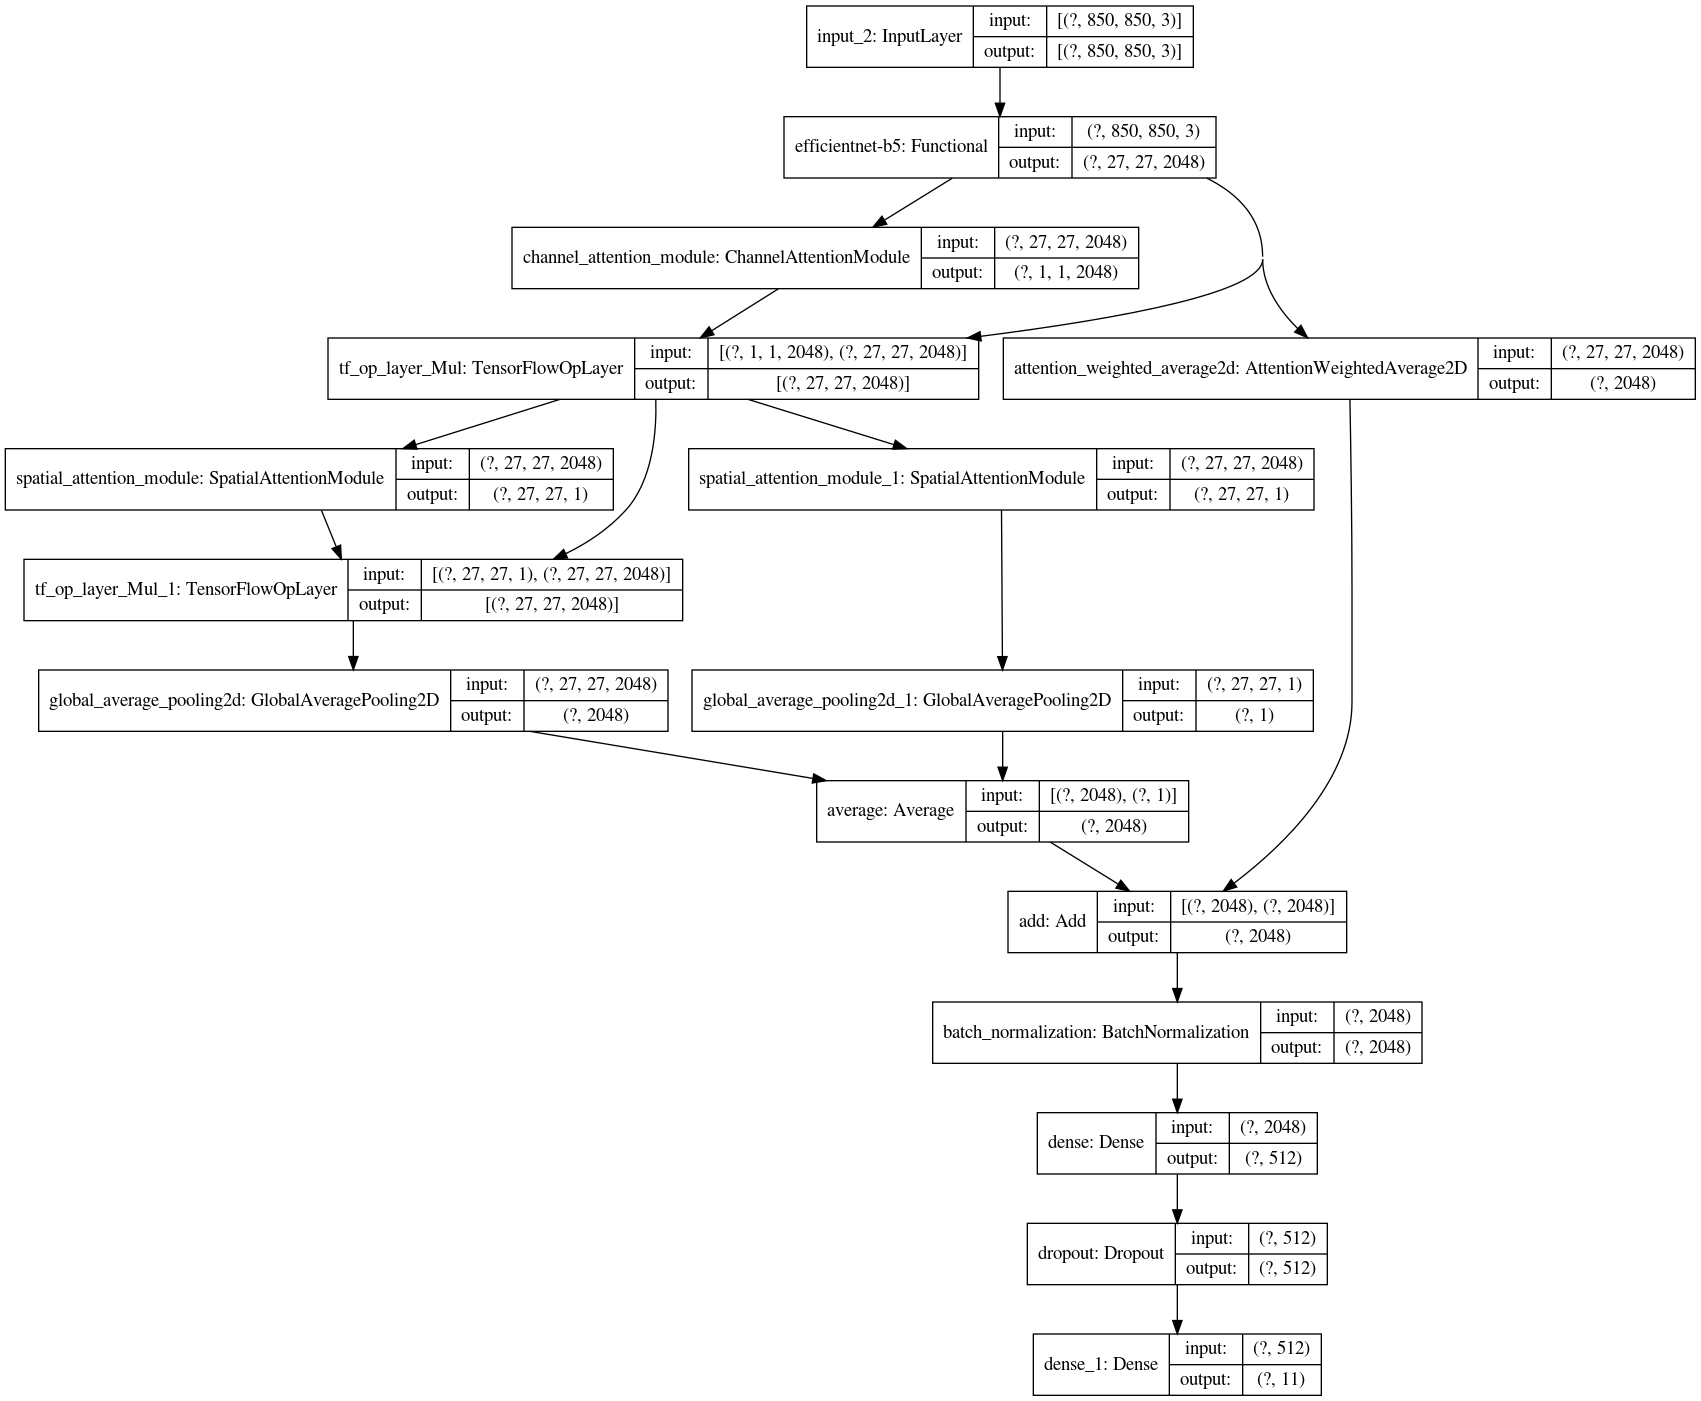

In [12]:
class RANZCRClassifier(tf.keras.Model):
    def __init__(self, dim):
        super(RANZCRClassifier, self).__init__()
        # Defining All Layers in __init__
        # Layer of Block
        self.Base  = efn.EfficientNetB5(
            input_shape=(TrainConfig.IMG_SIZE['0'],
                         TrainConfig.IMG_SIZE['0'], 3),
            weights=None,
            include_top=False)
        # Keras Built-in
        self.GAP1 = tf.keras.layers.GlobalAveragePooling2D()
        self.GAP2 = tf.keras.layers.GlobalAveragePooling2D()
        self.BAT  = tf.keras.layers.BatchNormalization()
        self.ADD  = tf.keras.layers.Add()
        self.AVG  = tf.keras.layers.Average()
        self.DROP = tf.keras.layers.Dropout(rate=0.5)
        # Customs
        self.CAN  = ChannelAttentionModule()
        self.SPN1 = SpatialAttentionModule()
        self.SPN2 = SpatialAttentionModule()
        self.AWG  = AttentionWeightedAverage2D()
        # Tail
        self.DENS = tf.keras.layers.Dense(512, activation=tf.nn.relu)
        self.OUT  = tf.keras.layers.Dense(len(target_cols), 
                                          activation='sigmoid', 
                                          dtype=tf.float32)
    
    def call(self, input_tensor, training=False):
        # Base Inputs
        x      = self.Base(input_tensor)
        # Attention Modules 1
        # Channel Attention + Spatial Attention 
        canx   = self.CAN(x)*x
        spnx   = self.SPN1(canx)*canx
        # Global Weighted Average Poolin
        gapx   = self.GAP1(spnx)
        wvgx   = self.GAP2(self.SPN2(canx))
        gapavg = self.AVG([gapx, wvgx])
        # Attention Modules 2
        # Attention Weighted Average (AWG)
        awgavg = self.AWG(x)
        # Summation of Attentions
        x = self.ADD([gapavg, awgavg])
        # Tails
        x = self.BAT(x)
        x = self.DENS(x)
        x  = self.DROP(x, training=training)
        return self.OUT(x)
    
    # AFAIK: The most convenient method to print model.summary() in suclassed model
    def build_graph(self):
        x = tf.keras.layers.Input(shape=(TrainConfig.IMG_SIZE['0'],
                                         TrainConfig.IMG_SIZE['0'],3))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))
    
# plot 
model = RANZCRClassifier((TrainConfig.IMG_SIZE['0'], 
                          TrainConfig.IMG_SIZE['0'], 3))
tf.keras.utils.plot_model(
    model.build_graph(), show_shapes=True, 
    show_layer_names=True, expand_nested=False                      
)

## <font color = "seagreen">Inference</font>

In [13]:
model = RANZCRClassifier((TrainConfig.IMG_SIZE['0'],TrainConfig.IMG_SIZE['0'], 3))
model.build((None, *(TrainConfig.IMG_SIZE['0'],TrainConfig.IMG_SIZE['0'], 3)))
model.load_weights('../input/multiattentioncheckwg/model.h5')

In [14]:
test_paths = BaseConfig.TEST_IMG_PATH + submit['StudyInstanceUID'] + '.jpg'
test_decoder = build_decoder(with_labels=False, 
                             target_size=(TrainConfig.IMG_SIZE['0'], 
                                          TrainConfig.IMG_SIZE['0']))
dtest = build_dataset(
    test_paths, bsize=TrainConfig.BATCH_SIZE['0'], 
    repeat=False, shuffle=False, augment=False, 
    cache=False, decode_fn=test_decoder
)

In [15]:
submit[target_cols] = model.predict(dtest, verbose=1)
submit.to_csv('submission.csv', index=False)
submit.head()

112/112 [==============================] - 292s 3s/step


,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
0,1.2.826.0.1.3680043.8.498.46923145579096002617...,2.208163e-05,2.539416e-02,9.708167e-01,1.479139e-05,7.429431e-04,3.008313e-03,9.940944e-01,0.006447,0.059842,0.968643,9.999943e-01
1,1.2.826.0.1.3680043.8.498.84006870182611080091...,1.069400e-09,3.707888e-08,3.857427e-07,4.198821e-07,8.645618e-08,6.542579e-09,8.789124e-08,0.049204,0.024251,0.956644,3.082640e-06
2,1.2.826.0.1.3680043.8.498.12219033294413119947...,1.110414e-10,2.721529e-08,2.237614e-08,2.845800e-07,2.130279e-06,1.291258e-08,9.623458e-08,0.002942,0.253688,0.812886,3.176127e-07
3,1.2.826.0.1.3680043.8.498.84994474380235968109...,5.419382e-04,1.187538e-04,2.124890e-05,9.107623e-03,7.470000e-04,9.905593e-01,2.024026e-03,0.048668,0.316277,0.732969,3.136972e-04
4,1.2.826.0.1.3680043.8.498.35798987793805669662...,2.853687e-09,3.941081e-07,2.147806e-06,3.483655e-07,1.494529e-06,2.056559e-09,1.747906e-05,0.002341,0.026494,0.986989,3.982171e-07
